In [1]:
# import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tfkan import layers
from tfkan.layers import DenseKAN, Conv2DKAN
from tensorflow.nn import silu

In [2]:
train_dir = 'G:/Amit/KMC Dataset for grading/Training'
test_dir = 'G:/Amit/KMC Dataset for grading/Test'
valid_dir = 'G:/Amit/KMC Dataset for grading/Validation'

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
batch_size= 4
img_height =224
img_width =224
no_of_classes = 5
classes_name=['grade0','grade1','grade2','grade3','grade4']
input_shape = (img_height, img_width, 3)

In [5]:
random_seed =np.random.seed(52)

In [6]:
# Generating batches of tensor Image data


datagen = ImageDataGenerator( rescale=1. / 255,
                             featurewise_center=True,
                             horizontal_flip = False,
                             vertical_flip = False,
                             #validation_split = 0.1,
                             featurewise_std_normalization=True)

train_generator = datagen.flow_from_directory(train_dir,
                                               target_size=(img_height, img_width),
                                               batch_size=batch_size,
                                               shuffle = True,
                                               class_mode='categorical')

validation_generator = datagen.flow_from_directory(valid_dir,
                                                   target_size=(img_height, img_width),
                                                   batch_size=batch_size,
                                                   shuffle = True,
                                                   class_mode='categorical')

Found 3432 images belonging to 5 classes.
Found 503 images belonging to 5 classes.


In [7]:
print(train_generator.class_indices)

{'grade0': 0, 'grade1': 1, 'grade2': 2, 'grade3': 3, 'grade4': 4}


In [8]:
# Training CNN model

from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers

In [9]:
# def conv_block(filter,x):
#   b0=Conv2D(filter,(3,3),padding='same')(x)
#   b1=BatchNormalization()(b0)
#   b2=Activation('relu')(b1)
#   return b2

# def conv_block1(filter,x):
#   b0=SeparableConv2D(filter,(3,3),padding='same')(x)
#   b1=BatchNormalization()(b0)
#   b2=Activation('relu')(b1)
#   return b2

# def residual_block(filter,x):
#   w,h,c = x.shape[1],x.shape[2],x.shape[3]
#   r0=AveragePooling2D(pool_size=(w,h))(x)
#   r0=Conv2D(filter,(1,1),activation='sigmoid',padding='same')(r0)
#   r1=Multiply()([x,r0])
#   return r1

# def context_guided(x,y):
#     x1 = tf.math.reduce_mean(x, axis=3, name=None,keepdims=True)
#     x2 = tf.math.reduce_max(x, axis=3, name=None,keepdims=True)
#     x12 = Concatenate()([x1,x2])
#     x12 = Conv2D(1,1)(x12)
#     x12 = Activation('sigmoid')(x12)
#     xy12 = Multiply()([y,x12])
#     xy = Add()([xy12,x])
#     return xy

# def scr_block(x,y,filters,gr):
#   _,width,height,channel=list(x.shape)
#   get_channel=channel//gr
#   x=Reshape([width,height,get_channel,gr])(x)
#   x=Permute([1,2,4,3])(x)
   
#   _,width,height,channel=list(y.shape)
#   get_channel=channel//gr
#   y=Reshape([width,height,get_channel,gr])(y)
#   y=Permute([1,2,4,3])(y)
  
#   for i in range(gr):
#         if i != 0 and i!=(gr-1):
#             concat1 = y[:,:,:,0]
#             for j in range(1,i):
#                 concat1 = Concatenate()([concat1,y[:,:,:,j]])
#             concat1 = Concatenate()([concat1,x[:,:,:,i]])
#             for j in range(i+1,gr):
#                 concat1 = Concatenate()([concat1,x[:,:,:,j]])
#         elif i == (gr-1):
#             concat1 = y[:,:,:,0]
#             for j in range(1,i):
#                 concat1 = Concatenate()([concat1,y[:,:,:,j]])
#             concat1 = Concatenate()([concat1,x[:,:,:,i]])
#         else:
#             concat1 = x[:,:,:,0]
#             for j in range(1,gr):
#                 concat1 = Concatenate()([concat1,y[:,:,:,j]])  
#         # conv3 = Conv2D(channel,1,padding='same',activation='relu')(concat1)

#         # conv3 = conv_block(channel,concat1)
#         res_x = residual_block(channel,concat1)
#         if i==0:
#             x_out = res_x
#         else:
#             x_out = Concatenate()([x_out,res_x])
#   x_out = Conv2D(channel,1,padding='same')(x_out)
#   return x_out

# def resnet_block(block_input,filters,gr):
#   conv1=conv_block(filters,block_input)
#   conv2=scr_block(block_input,conv1,filters,gr)
#   sum=Add()([conv2,block_input])
#   res_out=Activation('relu')(sum)
#   return res_out

# def rccgnet():
#   input = Input(shape=(224,224,3))
#   conv1 = conv_block(16,input)
#   scr1 = resnet_block(conv1,16,2)
#   scr2 = resnet_block(scr1,16,4)
#   Add1 = context_guided(scr1,scr2)
#   pool1 = AveragePooling2D((2,2),(2,2))(Add1)
#   conv2 = conv_block(32,pool1)
#   scr3 = resnet_block(conv2,32,2)
#   scr4 = resnet_block(scr3,32,8)
#   Add2 = context_guided(scr3,scr4)
#   pool2 = AveragePooling2D((2,2),(2,2))(Add2)
#   conv3 = conv_block(64,pool2)
#   scr5 = resnet_block(conv3,64,4)
#   scr6 = resnet_block(scr5,64,8)
#   Add3 = context_guided(scr5,scr6)
#   pool3 = GlobalAveragePooling2D()(Add3)
#   output = Dense(5, activation='softmax')(pool3)
#   model = Model(inputs = input, outputs = output)
#   return model

In [10]:
def conv_block(filter,x):
  b0=Conv2D(filter,(3,3),padding='same')(x)
  b1=BatchNormalization()(b0)
  b2=Activation('relu')(b1)
  return b2

# def conv_block1(filter,x):
#   b0=SeparableConv2D(filter,(3,3),padding='same')(x)
#   b1=BatchNormalization()(b0)
#   b2=Activation('relu')(b1)
#   return b2

def residual_block(filter,x):
  w,h,c = x.shape[1],x.shape[2],x.shape[3]
  r0=AveragePooling2D(pool_size=(w,h))(x)
  r0=Conv2D(filter,(1,1),activation='sigmoid',padding='same')(r0)
  r1=Multiply()([x,r0])
  return r1


# def residual_block(filter,x,ratio=8):
#   w,h,c = x.shape[1],x.shape[2],x.shape[3]
#   r0=AveragePooling2D(pool_size=(w,h))(x)
#   r0=Dense(x.shape[3]//ratio,activation='relu')(r0)
#   r0=Dense(x.shape[3],activation='sigmoid')(r0)
#   r1=Multiply()([x,r0])
#   return r1

def context_guided(x,y):
    x1 = tf.math.reduce_mean(x, axis=3, name=None,keepdims=True)
    x2 = tf.math.reduce_max(x, axis=3, name=None,keepdims=True)
    x12 = Concatenate()([x1,x2])
    x12 = Conv2D(1,1)(x12)
    x12 = Activation('sigmoid')(x12)
    xy12 = Multiply()([y,x12])
    xy = Add()([xy12,x])
    return xy


def scr_block(x,y,filters,gr):
  y1 = y
  _,width,height,channel=list(x.shape)
  get_channel=channel//gr
  x=Reshape([width,height,get_channel,gr])(x)
  x=Permute([1,2,4,3])(x)
   
  _,width,height,channel=list(y.shape)
  get_channel=channel//gr
  y=Reshape([width,height,get_channel,gr])(y)
  y=Permute([1,2,4,3])(y)

  for i in range(gr):
        if i != 0 and i!=(gr-1):
            concat1 = y[:,:,:,0]
            for j in range(1,i):
                concat1 = Concatenate()([concat1,y[:,:,:,j]])
            concat1 = Concatenate()([concat1,x[:,:,:,i]])
            for j in range(i+1,gr):
                concat1 = Concatenate()([concat1,x[:,:,:,j]])
        elif i == (gr-1):
            concat1 = y[:,:,:,0]
            for j in range(1,i):
                concat1 = Concatenate()([concat1,y[:,:,:,j]])
            concat1 = Concatenate()([concat1,x[:,:,:,i]])
        else:
            concat1 = x[:,:,:,0]
            for j in range(1,gr):
                concat1 = Concatenate()([concat1,y[:,:,:,j]])  
        res_x = residual_block(channel,concat1)

        if i==0:
            x_out = res_x
        else:
            x_out = Concatenate()([x_out,res_x])
  x_out = Conv2D(channel,1,padding='same',activation='relu')(x_out)
  x_out = context_guided(x_out,y1)
  print(x_out.shape)
  x_out = Conv2D(channel,1,padding='same')(x_out)

  return x_out

def resnet_block(block_input,filters,gr):
  conv1=conv_block(filters,block_input)
  conv2=scr_block(block_input,conv1,filters,gr)
  sum=Add()([conv2,block_input])
  res_out=Activation('relu')(sum)
  return res_out

def rccgnet():
  input = Input(shape=(224,224,3))
  conv1 = conv_block(16,input)
  scr1 = resnet_block(conv1,16,2)
  scr2 = resnet_block(conv1,16,4)
  scr3 = resnet_block(conv1,16,8)
  Add1 = Add()([scr1,scr2,scr3])
  pool1 = AveragePooling2D((2,2),(2,2))(Add1)
  conv2 = conv_block(32,pool1)
  scr4 = resnet_block(conv2,32,2)
  scr5 = resnet_block(conv2,32,4)
  scr6 = resnet_block(conv2,32,8)
  Add2 = Add()([scr4,scr5,scr6])
  pool2 = MaxPooling2D((2,2),(2,2))(Add2)
  conv3 = conv_block(64,pool2)
  scr7 = resnet_block(conv3,64,2)
  scr8 = resnet_block(conv3,64,4)
  scr9 = resnet_block(conv3,64,8)
  Add3 = Add()([scr7,scr8,scr9])
  pool3 = GlobalAveragePooling2D()(Add3)
  output = Dense(5, activation='softmax')(pool3)
  model = Model(inputs = input, outputs = output)
  return model

In [ ]:
def conv_block(filter,x):
  b0=Conv2D(filter,(3,3),padding='same')(x)
  b1=BatchNormalization()(b0)
  b2=Activation('relu')(b1)
  return b2

# def conv_block1(filter,x):
#   b0=SeparableConv2D(filter,(3,3),padding='same')(x)
#   b1=BatchNormalization()(b0)
#   b2=Activation('relu')(b1)
#   return b2

def residual_block(filter,x):
  w,h,c = x.shape[1],x.shape[2],x.shape[3]
  r0=AveragePooling2D(pool_size=(w,h))(x)
  r0=Conv2D(filter,(1,1),activation='sigmoid',padding='same')(r0)
  r1=Multiply()([x,r0])
  return r1


# def residual_block(filter,x,ratio=8):
#   w,h,c = x.shape[1],x.shape[2],x.shape[3]
#   r0=AveragePooling2D(pool_size=(w,h))(x)
#   r0=Dense(x.shape[3]//ratio,activation='relu')(r0)
#   r0=Dense(x.shape[3],activation='sigmoid')(r0)
#   r1=Multiply()([x,r0])
#   return r1

def context_guided(x,y):
    x1 = tf.math.reduce_mean(x, axis=3, name=None,keepdims=True)
    x2 = tf.math.reduce_max(x, axis=3, name=None,keepdims=True)
    x12 = Concatenate()([x1,x2])
    x12 = Conv2D(1,1)(x12)
    x12 = Activation('sigmoid')(x12)
    xy12 = Multiply()([y,x12])
    xy = Add()([xy12,x])
    return xy


def scr_block(x,y,filters,gr):
  y1 = y
  _,width,height,channel=list(x.shape)
  get_channel=channel//gr
  x=Reshape([width,height,get_channel,gr])(x)
  x=Permute([1,2,4,3])(x)
   
  _,width,height,channel=list(y.shape)
  get_channel=channel//gr
  y=Reshape([width,height,get_channel,gr])(y)
  y=Permute([1,2,4,3])(y)

  for i in range(gr):
        if i != 0 and i!=(gr-1):
            concat1 = y[:,:,:,0]
            for j in range(1,i):
                concat1 = Concatenate()([concat1,y[:,:,:,j]])
            concat1 = Concatenate()([concat1,(x[:,:,:,i]+y[:,:,:,i])])
            for j in range(i+1,gr):
                concat1 = Concatenate()([concat1,x[:,:,:,j]])
        elif i == (gr-1):
            concat1 = y[:,:,:,0]
            for j in range(1,i):
                concat1 = Concatenate()([concat1,y[:,:,:,j]])
            concat1 = Concatenate()([concat1,(x[:,:,:,i]+y[:,:,:,i])])
        else:
            concat1 = x[:,:,:,0]+y[:,:,:,0]
            for j in range(1,gr):
                concat1 = Concatenate()([concat1,y[:,:,:,j]])  
        res_x = residual_block(channel,concat1)

        if i==0:
            x_out = res_x
        else:
            x_out = Concatenate()([x_out,res_x])
  x_out = Conv2D(channel,1,padding='same',activation='relu')(x_out)
  x_out = context_guided(x_out,y1)
  print(x_out.shape)
  x_out = Conv2D(channel,1,padding='same')(x_out)

  return x_out

def resnet_block(block_input,filters,gr):
  conv1=conv_block(filters,block_input)
  conv2=scr_block(block_input,conv1,filters,gr)
  sum=Add()([conv2,block_input])
  res_out=Activation('relu')(sum)
  return res_out

def rccgnet():
  input = Input(shape=(224,224,3))
  conv1 = conv_block(16,input)
  scr1 = resnet_block(conv1,16,2)
  scr2 = resnet_block(conv1,16,4)
  scr3 = resnet_block(conv1,16,8)
  Add1 = Add()([scr1,scr2,scr3])
  pool1 = AveragePooling2D((2,2),(2,2))(Add1)
  conv2 = conv_block(32,pool1)
  scr4 = resnet_block(conv2,32,2)
  scr5 = resnet_block(conv2,32,4)
  scr6 = resnet_block(conv2,32,8)
  Add2 = Add()([scr4,scr5,scr6])
  pool2 = MaxPooling2D((2,2),(2,2))(Add2)
  conv3 = conv_block(64,pool2)
  scr7 = resnet_block(conv3,64,2)
  scr8 = resnet_block(conv3,64,4)
  scr9 = resnet_block(conv3,64,8)
  Add3 = Add()([scr7,scr8,scr9])
  pool3 = GlobalAveragePooling2D()(Add3)
  output = Dense(5, activation='softmax')(pool3)
  model = Model(inputs = input, outputs = output)
  return model

In [11]:
model = rccgnet()
model.compile(optimizer = 'Adam' , loss = 'categorical_crossentropy' , metrics = ["acc"])
model.summary()

(None, 224, 224, 16)
(None, 224, 224, 16)
(None, 224, 224, 16)
(None, 112, 112, 32)
(None, 112, 112, 32)
(None, 112, 112, 32)
(None, 56, 56, 64)
(None, 56, 56, 64)
(None, 56, 56, 64)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 224, 224, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation

In [12]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_acc' , mode='max' ,
                                                  factor = 0.5 , patience = 8 , verbose=1 , cooldown = 1,
                                                 min_delta = 0.0001)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_acc', min_delta=0.0001, patience=30, verbose=1,
                                              mode = 'max', restore_best_weights = True)
check_path = r'G:\Akshaya\Proposed_model_KMC_13.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(check_path, monitor = 'val_acc', verbose=1, save_best_only=True, save_weights_only=True, mode='max')


history_1 = model.fit(train_generator , validation_data = validation_generator ,
                                  steps_per_epoch= len(train_generator) ,
                                  validation_steps = len(validation_generator)
                                  ,epochs = 65,callbacks = [reduce_lr, early_stop, checkpoint] )

C:\Users\user\anaconda3\envs\ISRO_Project_2020\lib\site-packages\keras_preprocessing\image\image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\user\anaconda3\envs\ISRO_Project_2020\lib\site-packages\keras_preprocessing\image\image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/65
858/858 [==============================] - 186s 198ms/step - loss: 0.9873 - acc: 0.6096 - val_loss: 2.5961 - val_acc: 0.3439

Epoch 00001: val_acc improved from -inf to 0.34394, saving model to G:\Akshaya\Proposed_model_KMC_13.h5
Epoch 2/65
858/858 [==============================] - 174s 203ms/step - loss: 0.7167 - acc: 0.7226 - val_loss: 9.5981 - val_acc: 0.2724

Epoch 00002: val_acc did not improve from 0.34394
Epoch 3/65
858/858 [==============================] - 176s 205ms/step - loss: 0.5653 - acc: 0.7850 - val_loss: 5.7574 - val_acc: 0.4215

Epoch 00003: val_acc improved from 0.34394 to 0.42147, saving model to G:\Akshaya\Proposed_model_KMC_13.h5
Epoch 4/65
858/858 [==============================] - 178s 208ms/step - loss: 0.5008 - acc: 0.8106 - val_loss: 21.1757 - val_acc: 0.2028

Epoch 00004: val_acc did not improve from 0.42147
Epoch 5/65
858/858 [==============================] - 178s 207ms/step - loss: 0.4186 - acc: 0.8328 - val_loss: 2.6696 - val_acc: 0.4811

Epo

In [13]:
np.save('G:/Akshaya/Proposed_model_KMC_13.npy',history_1.history)

In [14]:
model.load_weights('G:\Akshaya\Proposed_model_KMC_13.h5')

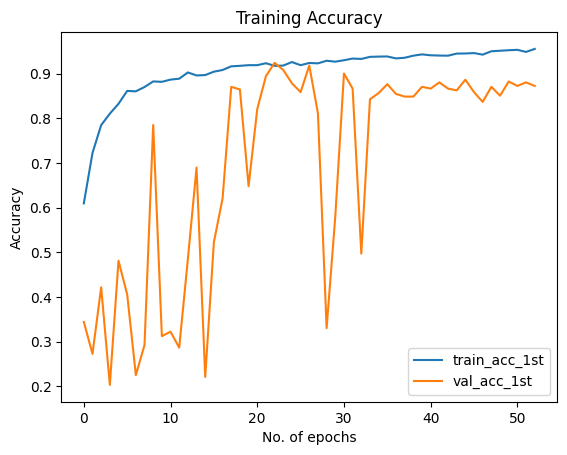

In [15]:
a=np.load('G:/Akshaya/Proposed_model_KMC_13.npy',allow_pickle='TRUE').item()
plt.plot(a['acc'] , label = 'train_acc_1st')
plt.plot(a['val_acc'] , label = 'val_acc_1st')
plt.legend()
plt.xlabel("No. of epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy")
plt.show()

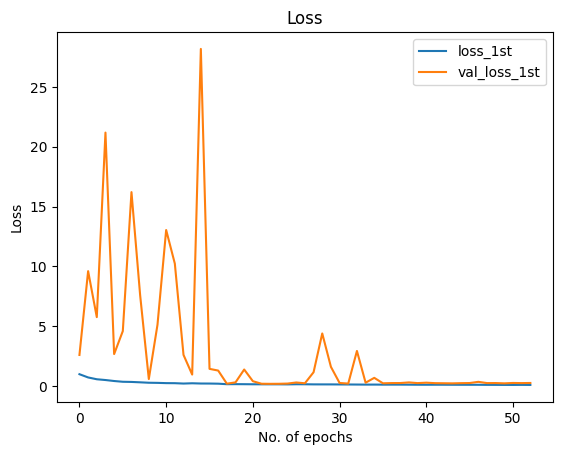

In [16]:
plt.plot(a['loss'] , label = 'loss_1st')
plt.plot(a['val_loss'] , label = 'val_loss_1st')
plt.legend()
plt.xlabel("No. of epochs")
plt.ylabel("Loss")
plt.title("Loss")
plt.show()

In [17]:
test_d = ImageDataGenerator(rescale=1. / 255)
test = test_d.flow_from_directory(
    test_dir,
    target_size=(224,224),
    batch_size=1,
    shuffle = False,
    class_mode='categorical')

import numpy as np
test_step = test.n//test.batch_size
test.reset()
pred = model.predict_generator(test , steps = test_step , verbose = 1)
pred_class_indices = np.argmax(pred,axis=1)

## printing predicted labels
print(pred_class_indices)

from sklearn.metrics import accuracy_score,roc_curve, confusion_matrix, roc_auc_score, auc, f1_score,jaccard_score,classification_report
from sklearn.metrics import precision_score,recall_score,jaccard_score
classes = [0,1,2,3,4]


for cl in classes:

    print("class: ",cl)

    a1 = np.uint8(test.labels == cl)
    a2 = np.uint8(pred_class_indices == cl)

    print('Accuracy {}'.format(accuracy_score(y_true=a1, y_pred=a2)))
    print('F1 {}'.format(f1_score(y_true=a1, y_pred=a2)))
    print('precision {}'.format(precision_score(y_true=a1, y_pred=a2)))
    print('recall {}'.format(recall_score(y_true=a1, y_pred=a2)))

    print('jaccard {}'.format(jaccard_score(y_true=a1, y_pred=a2)))
    print("_______________________________")


print('Accuracy {}'.format(accuracy_score(y_true=test.labels, y_pred=pred_class_indices)))
print('F1 {}'.format(f1_score(y_true=test.labels, y_pred=pred_class_indices,average = "macro")))
print('precision {}'.format(precision_score(y_true=test.labels, y_pred=pred_class_indices,average = "macro")))
print('recall {}'.format(recall_score(y_true=test.labels, y_pred=pred_class_indices,average = "macro")))

print('jaccard {}'.format(jaccard_score(y_true=test.labels, y_pred=pred_class_indices,average = "macro")))
print('confusion_matrix\n {}'.format(confusion_matrix(y_true=test.labels, y_pred=pred_class_indices)))
print('classification_report\n {}'.format(classification_report(y_true=test.labels, y_pred=pred_class_indices)))
print('\n\n')

Found 506 images belonging to 5 classes.


C:\Users\user\anaconda3\envs\ISRO_Project_2020\lib\site-packages\tensorflow\python\keras\engine\training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


506/506 [==============================] - 17s 29ms/step
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 4 2 2 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 3 3 3 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 3 3 3 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3
 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 4 4 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 0 